In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import tensorflow as tf


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Problem Statement



Company of Electrolysia supplies electricity to the city. It is looking to optimise its electricity production based on the historical electricity consumption of the people of Electrovania. 
 
The company has hired you as a Data Scientist to investigate the past consumption and the weather information to come up with a model that catches the trend as accurately as possible. You have to bear in mind that there are many factors that affect electricity consumption and not all can be measured. Electrolysia has provided you this data on hourly data spanning five years. 
 
For this competition, the training set is comprised of the first 23 days of each month and the test set is the 24th to the end of the month, where the public leaderboard is based on the first two days of test, whereas the private leaderboard considers the rest of the days. Your task is to predict the electricity consumption on hourly basis.



In [2]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
train_df=pd.read_csv("My Drive/Colab Notebooks/AV/JanataHack Time Series Forecasting/train_6BJx641.csv")

In [4]:
test_df=pd.read_csv("My Drive/Colab Notebooks/AV/JanataHack Time Series Forecasting/test_pavJagI.csv")

# Data Processing

In [5]:
print(train_df.shape)
print(test_df.shape)

(26496, 8)
(8568, 7)


In [6]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   datetime                 26496 non-null  object 
 2   temperature              26496 non-null  float64
 3   var1                     26496 non-null  float64
 4   pressure                 26496 non-null  float64
 5   windspeed                26496 non-null  float64
 6   var2                     26496 non-null  object 
 7   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB
None


In [7]:
# lets convert eh datetime column
train_df.datetime=train_df.datetime.apply(pd.to_datetime)


In [8]:
train_df.nunique()

ID                         26496
datetime                   26496
temperature                   60
var1                          71
pressure                      73
windspeed                   5603
var2                           3
electricity_consumption      252
dtype: int64

In [9]:
# droping ID
train_df.drop("ID",axis=1, inplace=True)

In [10]:
# null value check
train_df.isnull().sum()

datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

the values for the test are clearly the ones missing

In [11]:
train_df.head()

,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


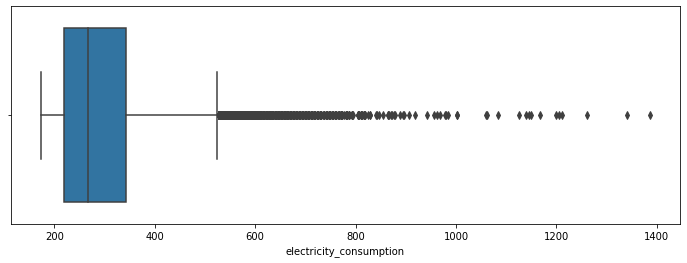

In [12]:
fig = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=train_df.electricity_consumption,whis=1.5)

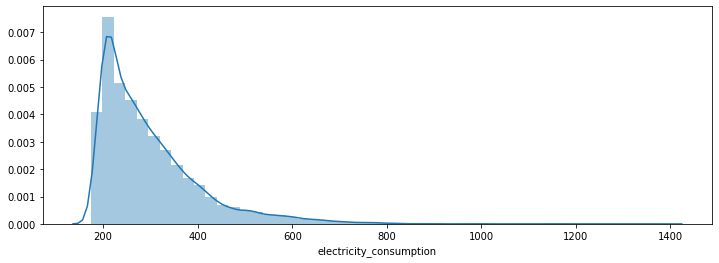

In [13]:
fig = plt.subplots(figsize=(12, 4))
sns.distplot(train_df.electricity_consumption)

In [14]:
train_df.electricity_consumption.describe(percentiles=[.25,.50,.75,.90,.95])

count    26496.000000
mean       298.359601
std        108.020555
min        174.000000
25%        219.000000
50%        267.000000
75%        342.000000
90%        435.000000
95%        519.000000
max       1386.000000
Name: electricity_consumption, dtype: float64

# Analysis

We take a multivariate time series approach as we have features that are related to the dependent variable 

# Feature Engineering


In [15]:
train=train_df.copy()
train["Month"]=train.datetime.dt.month
train["Weekday"]=train.datetime.dt.weekday
train["Year"]=train.datetime.dt.year
train["Hour"]=train.datetime.dt.hour
train["Minute"]=train.datetime.dt.minute
train["Day"]=train.datetime.dt.day
train["Is_month_start"]=train.datetime.dt.is_month_start*1
train["Is_month_end"]=train.datetime.dt.is_month_end*1
train["Is_weekend"]=train.datetime.dt.weekday.isin([5,6])*1
train.drop('datetime',axis=1,inplace=True)



# Encode var2
le=LabelEncoder()
le.fit(list(set(train.var2)))
train.var2=le.transform(train.var2)

In [16]:
train.head()

,temperature,var1,pressure,windspeed,var2,electricity_consumption,Month,Weekday,Year,Hour,Minute,Day,Is_month_start,Is_month_end,Is_weekend
0,-11.4,-17.1,1003.0,571.910,0,216.0,7,0,2013,0,0,1,1,0,0
1,-12.1,-19.3,996.0,575.040,0,210.0,7,0,2013,1,0,1,1,0,0
2,-12.9,-20.0,1000.0,578.435,0,225.0,7,0,2013,2,0,1,1,0,0
3,-11.4,-17.1,995.0,582.580,0,216.0,7,0,2013,3,0,1,1,0,0
4,-11.4,-19.3,1005.0,586.600,0,222.0,7,0,2013,4,0,1,1,0,0


In [17]:
# train_test_split
X=train.drop('electricity_consumption',axis=1)
y=train.electricity_consumption
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# Scale
min_max=MinMaxScaler()
X_train_scaled=min_max.fit_transform(X_train)
X_test_scaled=min_max.transform(X_test)

In [19]:
lr=LinearRegression()
lr.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
 def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):

  prediction = model.predict(X_test)
      
  plt.figure(figsize=(15, 8))
  plt.plot(y_test.values, label="actual", linewidth=2.0)
  plt.plot(prediction, "g", label="prediction", linewidth=2.0)
  
  if plot_intervals:
      cv = cross_val_score(model, X_train, y_train, 
                                 cv=KFold(n_splits=10),
                                  scoring="neg_mean_absolute_error")
      mae = cv.mean() * (-1)
      deviation = cv.std()
      
      scale = 2
      lower = prediction - (mae + scale * deviation)
      upper = prediction + (mae + scale * deviation)
      
      plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
      plt.plot(upper, "r--", alpha=0.5)
      
      if plot_anomalies:
          anomalies = np.array([np.NaN]*len(y_test))
          anomalies[y_test<lower] = y_test[y_test<lower]
          anomalies[y_test>upper] = y_test[y_test>upper]
          plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
  
  rsme = np.sqrt(mean_squared_error( y_test,prediction))
  mape = mean_absolute_percentage_error(y_test,prediction)
  plt.title("RSME {0:.2f}\n MAPE {1:.2f}%".format(rsme,mape) )
  plt.legend(loc="best")
  plt.tight_layout()
  plt.grid(True);

def plotCoefficients(model):
  """
      Plots sorted coefficient values of the model
  """
  
  coefs = pd.DataFrame(model.coef_, X_train.columns)
  coefs.columns = ["coef"]
  coefs["abs"] = coefs.coef.apply(np.abs)
  coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
  
  plt.figure(figsize=(15, 8))
  coefs.coef.plot(kind='bar')
  plt.grid(True, axis='y')
  plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');



In [22]:
def prepare_test_data():
  test=test_df.copy()
  test.datetime=test.datetime.apply(pd.to_datetime)

  test["Month"]=test.datetime.dt.month
  test["Weekday"]=test.datetime.dt.weekday
  test["Year"]=test.datetime.dt.year
  test["Hour"]=test.datetime.dt.hour
  test["Minute"]=test.datetime.dt.minute
  test["Day"]=test.datetime.dt.day
  test["Is_month_start"]=test.datetime.dt.is_month_start*1
  test["Is_month_end"]=test.datetime.dt.is_month_end*1
  test["Is_weekend"]=test.datetime.dt.weekday.isin([5,6])*1
  test.drop('datetime',axis=1,inplace=True)



  # Encode var2
  le=LabelEncoder()
  le.fit(list(set(test.var2)))
  test.var2=le.transform(test.var2)
  test.drop('ID',axis=1,inplace=True)
  test_scaled=min_max.transform(test)
  return test_scaled

test_scaled=prepare_test_data()

In [23]:
def create_submission_file(model,name):
  df=test_df.ID.to_frame()
  predictions=model.predict(test_scaled)
  df['electricity_consumption']= pd.Series(predictions)
  df.to_csv("My Drive/Colab Notebooks/AV/JanataHack Time Series Forecasting/"+name+".csv",index=False)

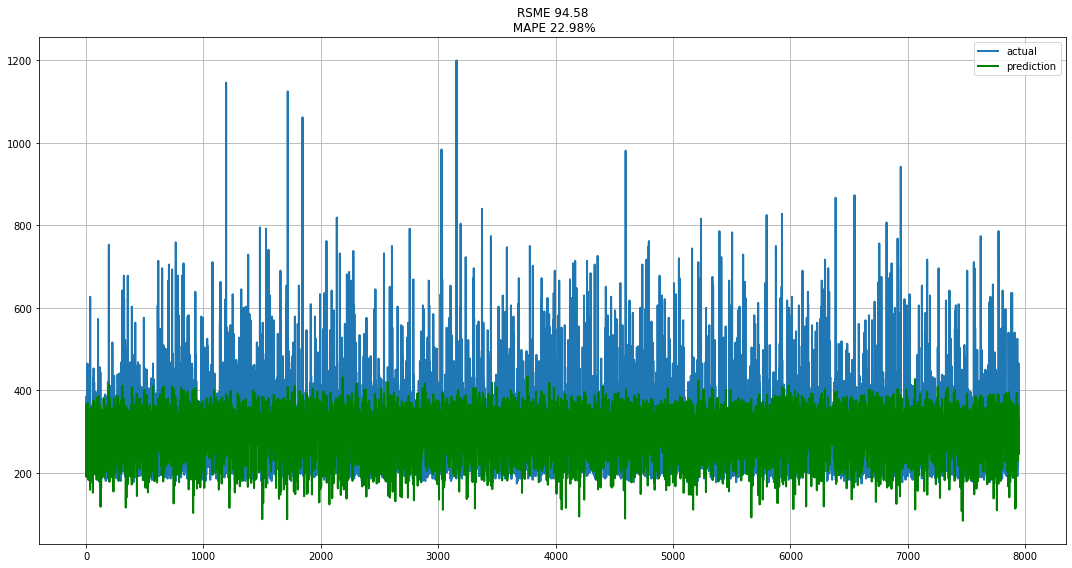

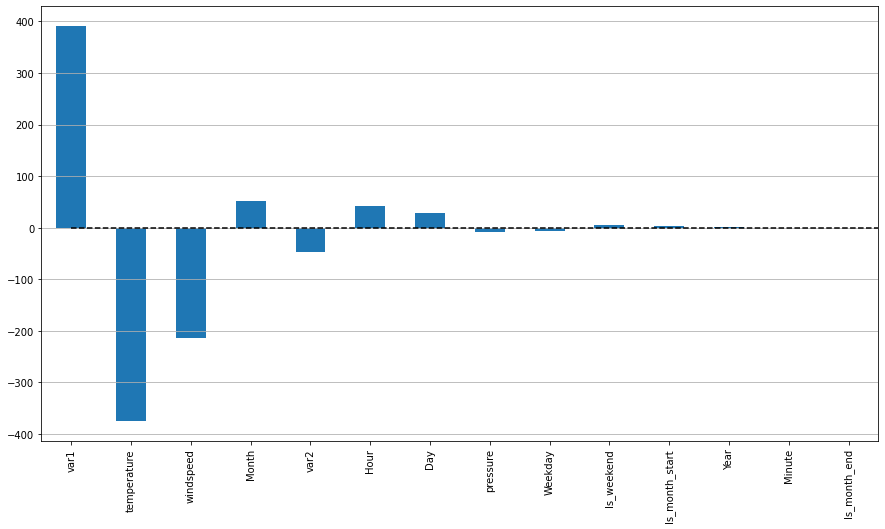

In [24]:
plotModelResults(lr,X_test=X_test_scaled)
plotCoefficients(lr)
create_submission_file(lr,"lr")

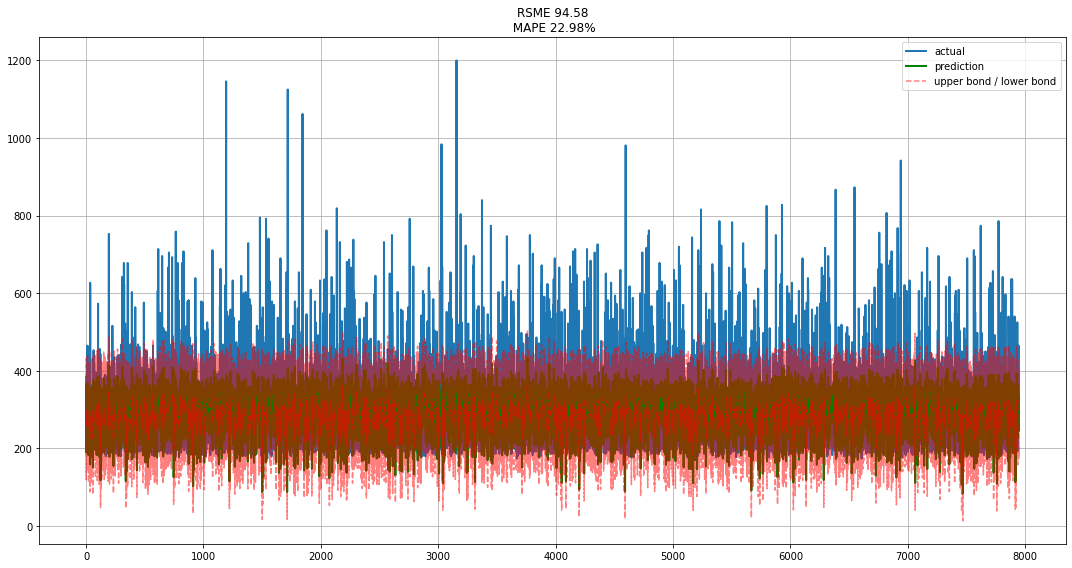

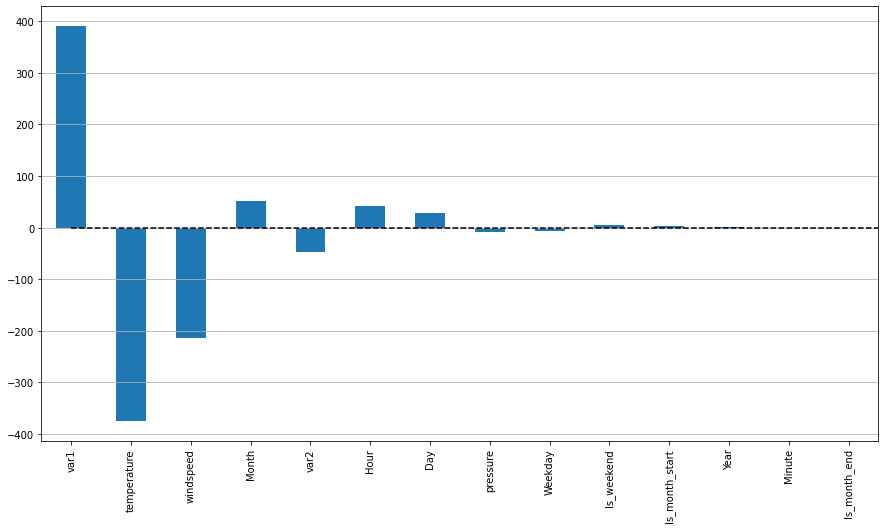

In [25]:
ridge=RidgeCV(cv=KFold(n_splits=10))
ridge.fit(X_train_scaled,y_train)


plotModelResults(ridge,plot_intervals=True,X_test=X_test_scaled)
plotCoefficients(ridge)
create_submission_file(ridge,"ridge")


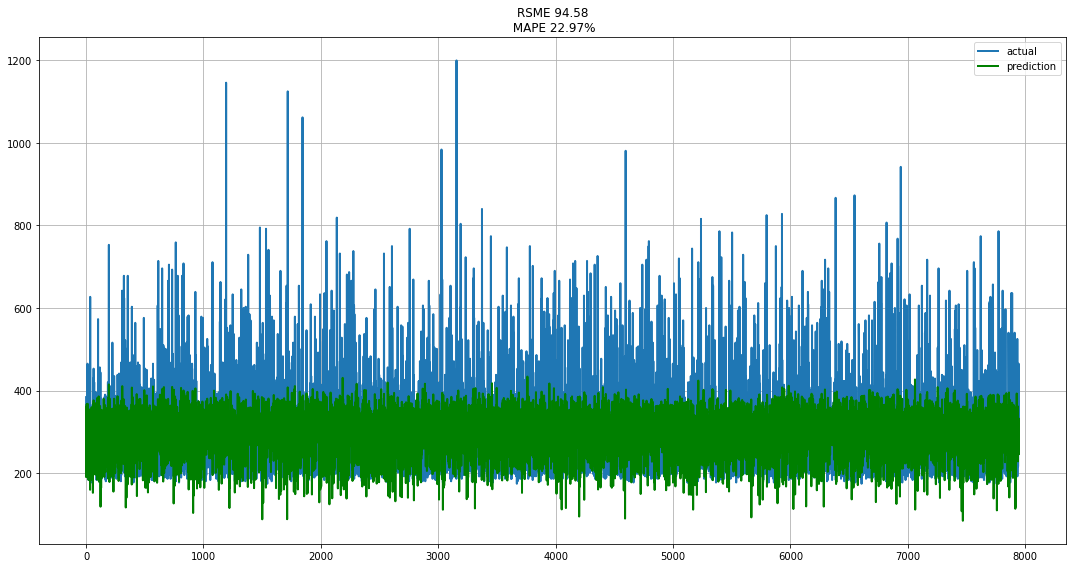

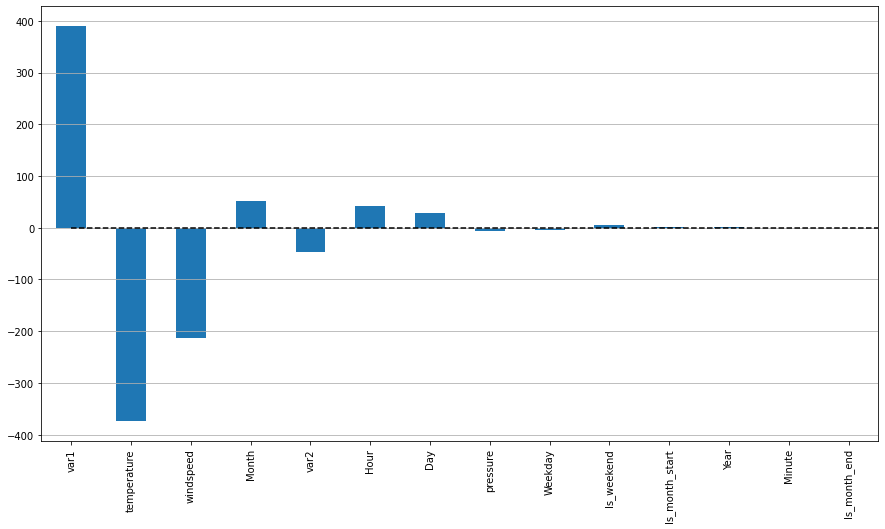

In [26]:
lasso=LassoCV(cv=KFold(n_splits=10))
lasso.fit(X_train_scaled,y_train)


plotModelResults(lasso,plot_intervals=False,X_test=X_test_scaled)
plotCoefficients(lasso)
create_submission_file(lasso,"lasso")


In [27]:
Xgb=XGBRegressor()
Xgb.fit(X_train_scaled,y_train)

[11:09:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

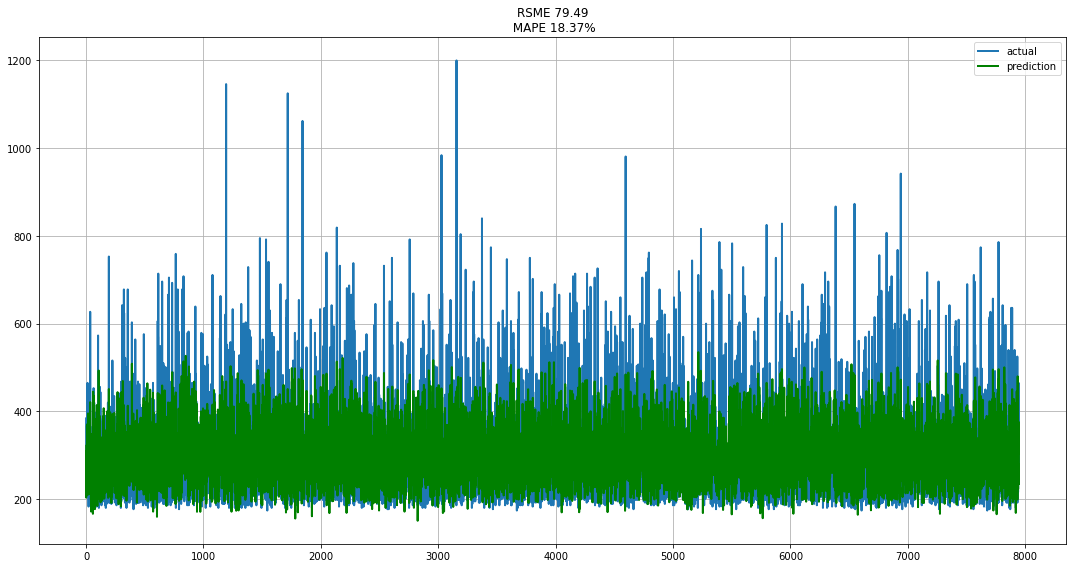

In [28]:
plotModelResults(Xgb,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(Xgb,"xgb")

In [29]:
# catboost=CatBoostRegressor(iterations=10)
# catboost.fit(X_train,y_train)

In [30]:
# plotModelResults(catboost,X_test=X_test_scaled)

In [31]:
lgbm=LGBMRegressor()
lgbm.fit(X_train_scaled,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

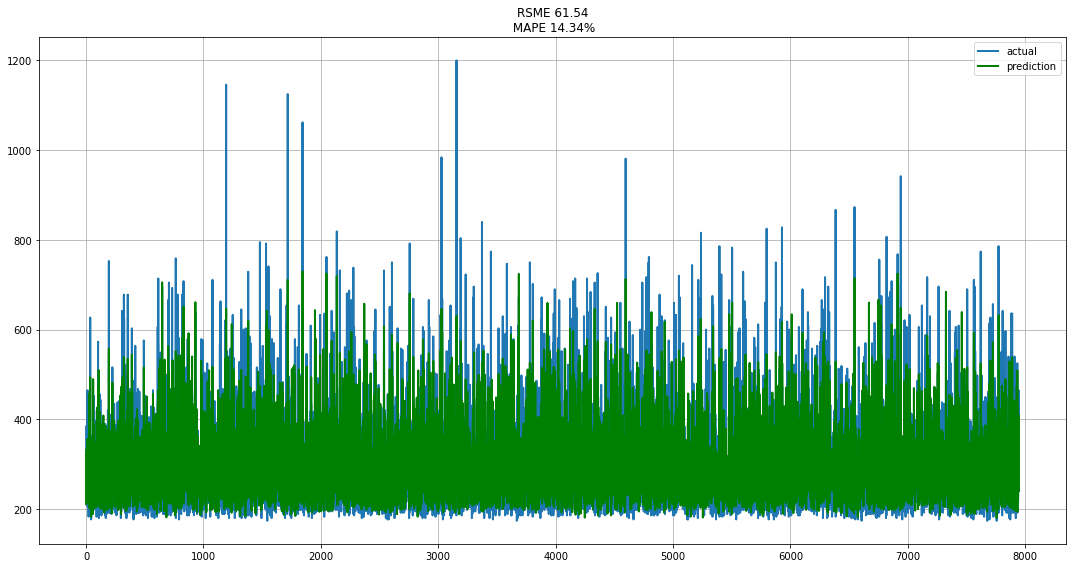

In [32]:
plotModelResults(lgbm, X_test=X_test_scaled)
create_submission_file(lgbm,"lgbm")

In [33]:
rf=RandomForestRegressor()
rf.fit(X_train_scaled,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

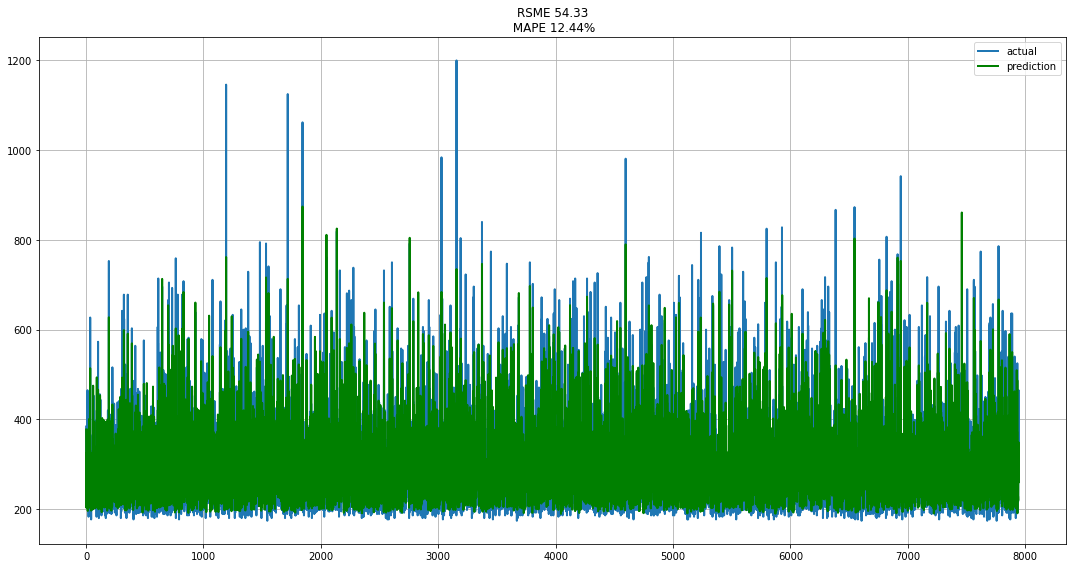

In [34]:
plotModelResults(rf,X_test=X_test_scaled)
create_submission_file(rf,"rf")

In [35]:
svr=SVR()
svr.fit(X_train_scaled,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

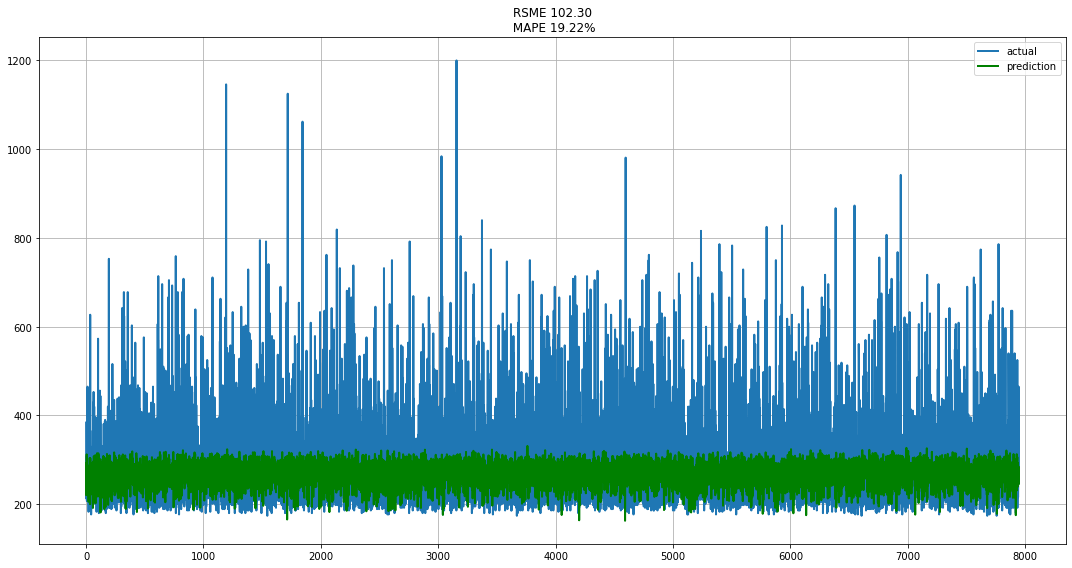

In [36]:
plotModelResults(svr,X_test=X_test_scaled)
create_submission_file(svr,"svr")

In [37]:
def baseline_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(14,activation='relu',kernel_initializer='he_uniform',input_shape=(14,)))
  model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer='he_uniform'))
  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1160/1160 [==============================] - 2s 2ms/step - loss: 75285.1484 - root_mean_squared_error: 274.3814
Epoch 2/100
1160/1160 [==============================] - 2s 2ms/step - loss: 21421.7695 - root_mean_squared_error: 146.3618
Epoch 3/100
1160/1160 [==============================] - 3s 2ms/step - loss: 13345.9170 - root_mean_squared_error: 115.5245
Epoch 4/100
1160/1160 [==============================] - 3s 2ms/step - loss: 12827.8057 - root_mean_squared_error: 113.2599
Epoch 5/100
1160/11

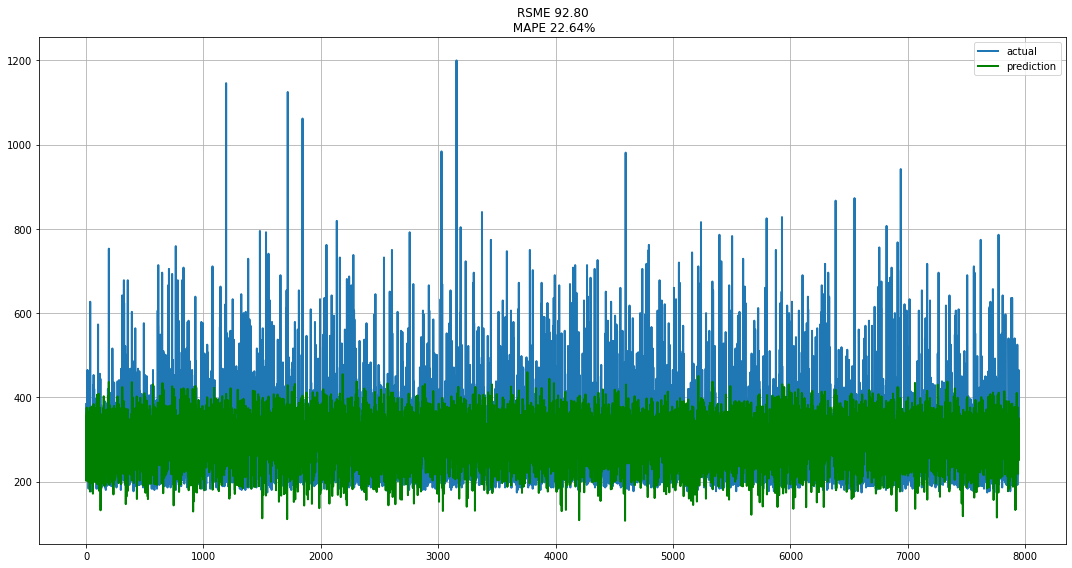

In [38]:

estimator = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=16, verbose=1)
estimator.fit(X_train_scaled,y_train)
plotModelResults(estimator,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(estimator,"baseline")

In [39]:
def deep_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(14,activation='relu',kernel_initializer='he_uniform',input_shape=(14,)))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  # model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  # model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer='he_uniform'))
  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,779
Trainable params: 1,779
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1160/1160 [==============================] - 3s 2ms/step - loss: 21186.7070 - root_mean_squared_error: 145.5565
Epoch 2/100
1160/1160 [==============================] - 3s 2ms/step - loss: 10389.1885 - root_mean_squared_error: 101.92

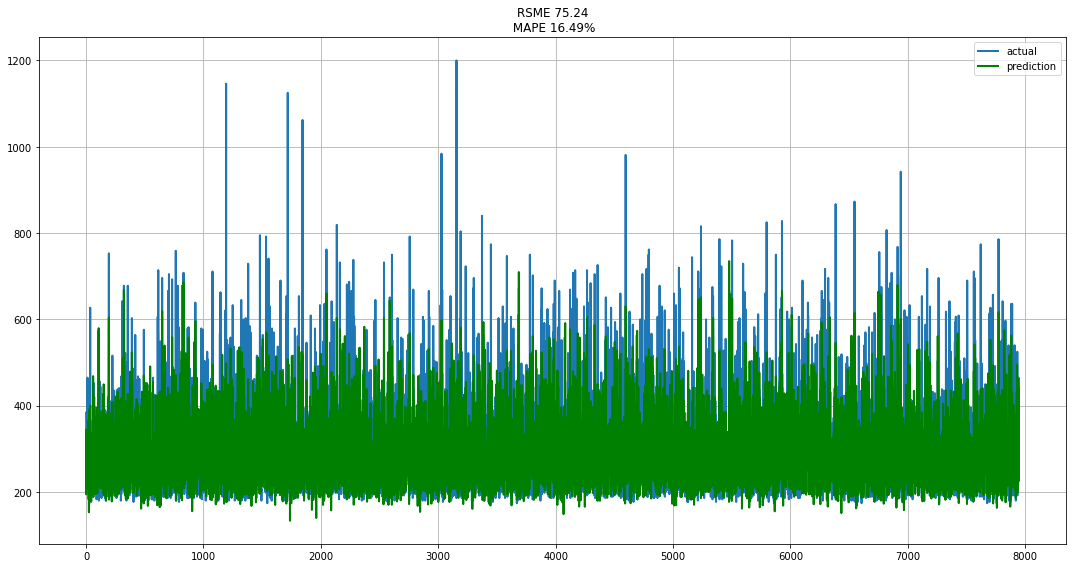

In [40]:
estimator = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=deep_model, epochs=100, batch_size=16, verbose=1)
estimator.fit(X_train_scaled,y_train)
plotModelResults(estimator,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(estimator,"deep_model")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                480       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,779
Trainable params: 1,779
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
580/580 [==============================] - 1s 2ms/step - loss: 32050.2832 - root_mean_squared_error: 179.0259
Epoch 2/100
580/580 [==============================] - 1s 2ms/step - loss: 11574.4375 - root_mean_squared_error: 107.5846
E

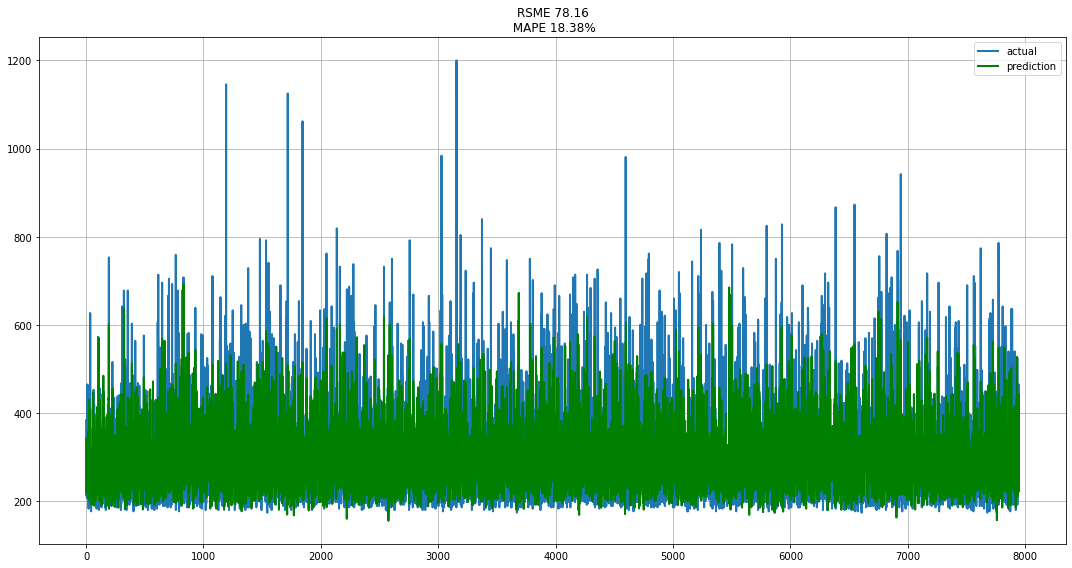

In [41]:
def deep_model_1():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(14,activation='relu',kernel_initializer='he_uniform',input_shape=(14,)))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  # model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  # model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer='he_uniform'))
  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  return model

estimator = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=deep_model_1, epochs=100, batch_size=32, verbose=1)
estimator.fit(X_train_scaled,y_train)
plotModelResults(estimator,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(estimator,"deep_model_1")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 2,867
Trainable params: 2,867
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1160/1160 [==============================] - 3s 2ms/step - loss: 20326.8145 - root_mean_squared_error: 142.5721
Epoch 2/100
1160/1160 [==============================] - 3s 2ms/step - loss: 9896.7998 - root_mean_squared_error: 99.4827

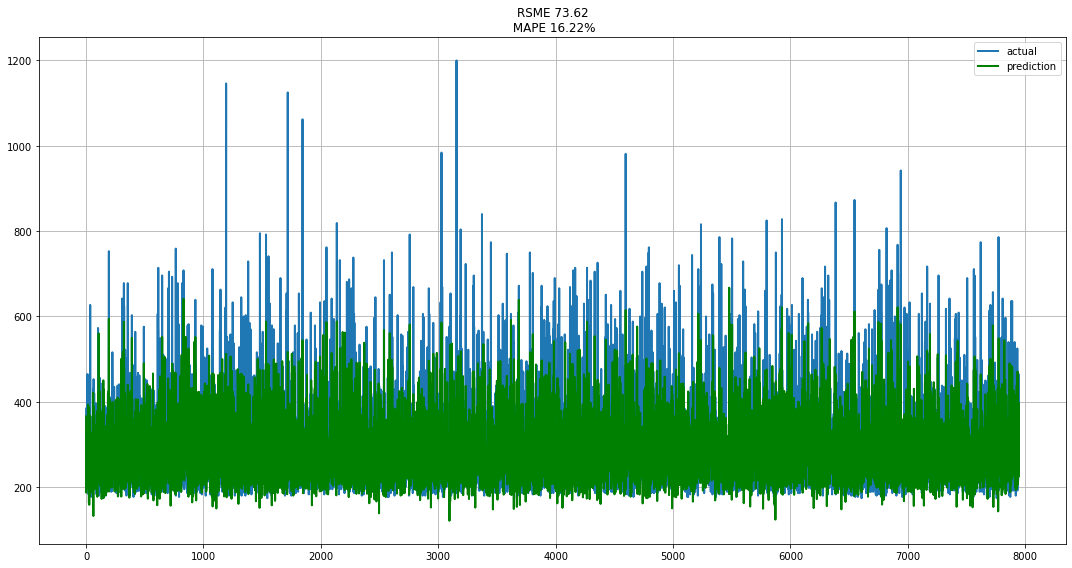

In [42]:
def deep_model_2():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(14,activation='relu',kernel_initializer='he_uniform',input_shape=(14,)))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer='he_uniform'))
  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  return model

estimator = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=deep_model_2, epochs=100, batch_size=16, verbose=1)
estimator.fit(X_train_scaled,y_train)
plotModelResults(estimator,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(estimator,"deep_model_2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 2,867
Trainable params: 2,867
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
580/580 [==============================] - 1s 2ms/step - loss: 30617.0078 - root_mean_squared_error: 174.9772
Epoch 2/100
580/580 [==============================] - 1s 2ms/step - loss: 10854.8516 - root_mean_squared_error: 104.1866
E

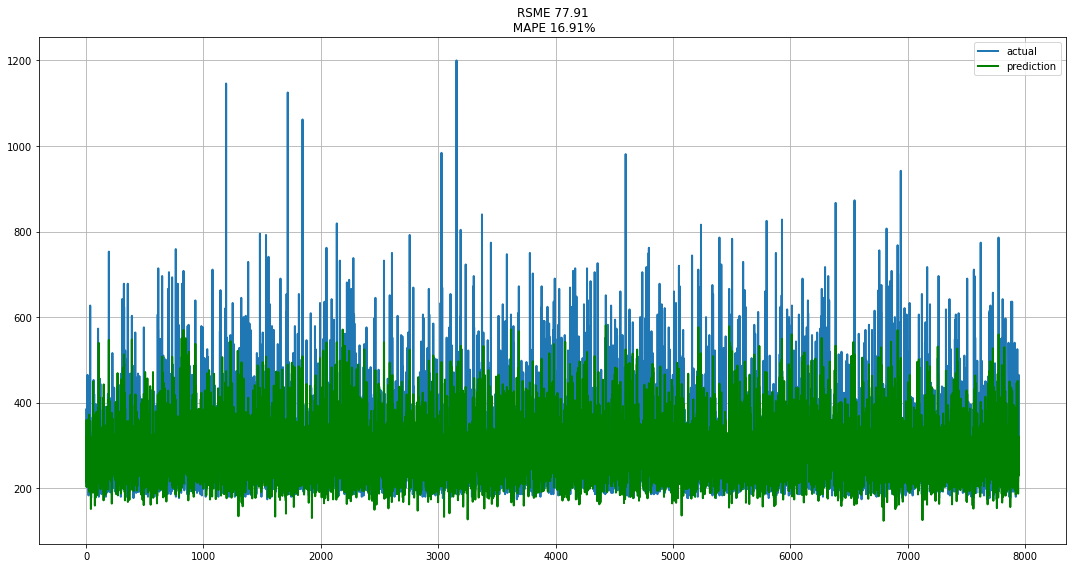

In [43]:
def deep_model_3():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(14,activation='relu',kernel_initializer='he_uniform',input_shape=(14,)))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer='he_uniform'))
  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  return model

estimator = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=deep_model_3, epochs=100, batch_size=32, verbose=1)
estimator.fit(X_train_scaled,y_train)
plotModelResults(estimator,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(estimator,"deep_model_3")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 4,915
Trainable params: 4,915
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1160/1160 [==============================] - 3s 2ms/step - loss: 17585.3477 - root_mean_squared_error

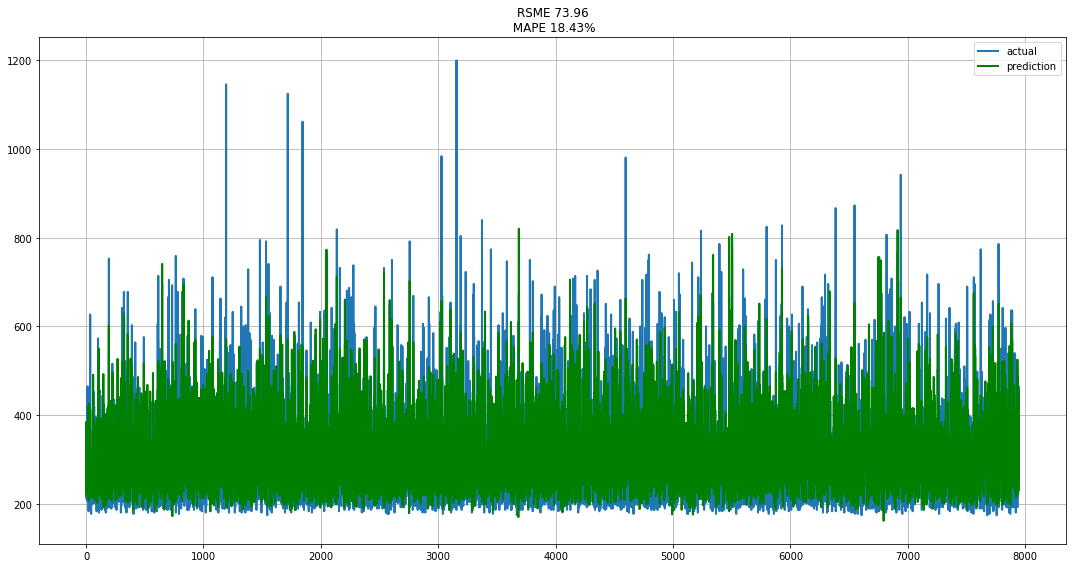

In [44]:
def deep_model_4():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(14,activation='relu',kernel_initializer='he_uniform',input_shape=(14,)))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer='he_uniform'))
  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  return model

estimator = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=deep_model_4, epochs=100, batch_size=16, verbose=1)
estimator.fit(X_train_scaled,y_train)
plotModelResults(estimator,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(estimator,"deep_model_4")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_24 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 7,027
Trainable params: 7,027
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1160/1160 [==============================] - 3s 2ms/step - loss: 17090.1484 - root_mean_squared_error

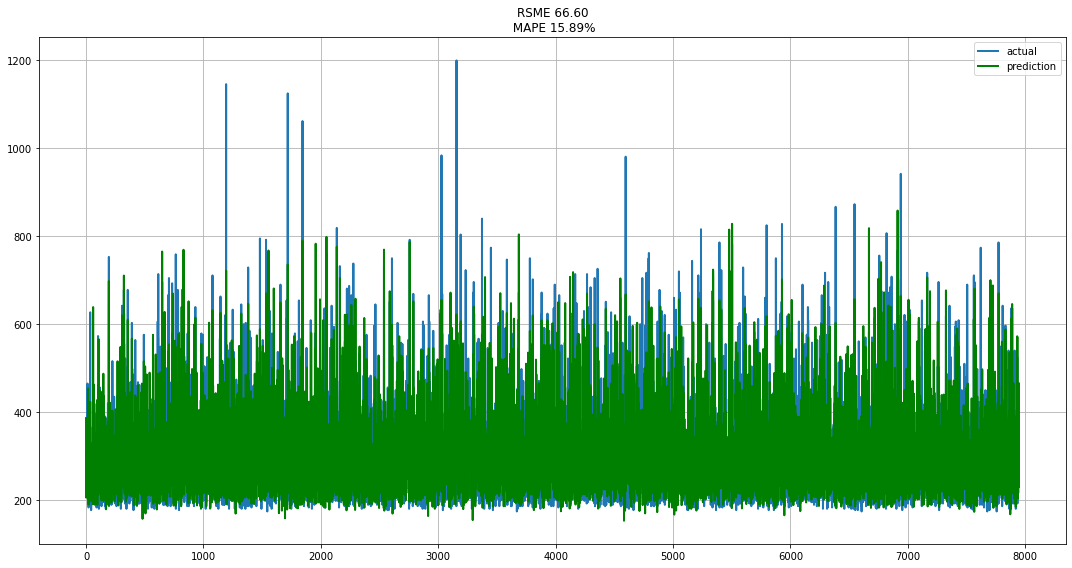

In [45]:
def deep_model_5():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(14,activation='relu',kernel_initializer='he_uniform',input_shape=(14,)))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  # model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  # model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  # model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer='he_uniform'))
  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  return model

estimator = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=deep_model_5, epochs=100, batch_size=16, verbose=1)
estimator.fit(X_train_scaled,y_train)
plotModelResults(estimator,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(estimator,"deep_model_5")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_29 (Dense)             (None, 64)                960       
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 7,443
Trainable params: 7,443
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1160/1160 [==============================] - 3s 2ms/step - loss: 17031.9512 - root_mean_squared_error

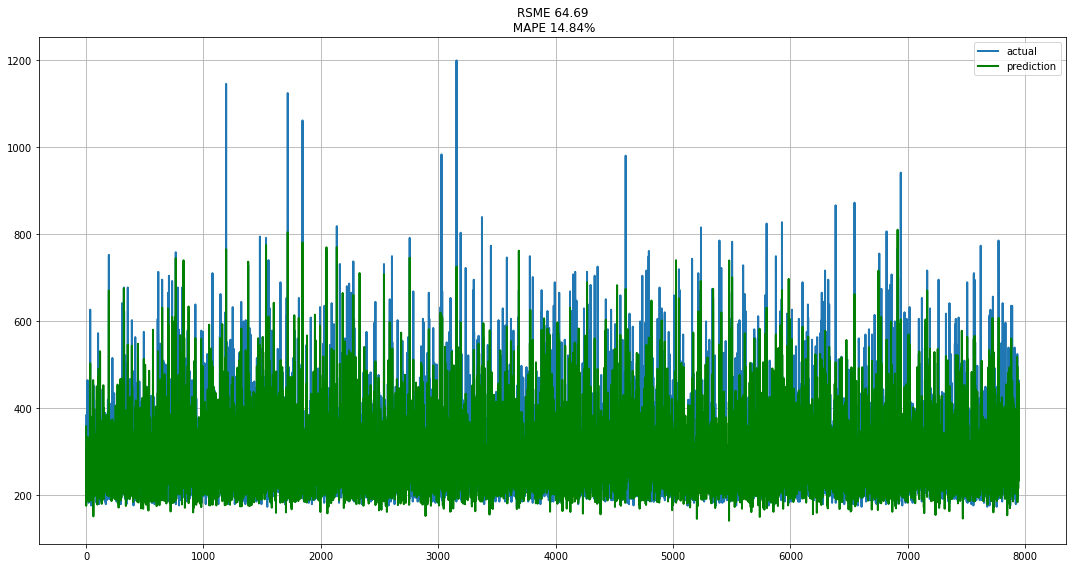

In [46]:
def deep_model_6():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(14,activation='relu',kernel_initializer='he_uniform',input_shape=(14,)))
  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer='he_uniform'))
  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  return model

estimator = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=deep_model_6, epochs=100, batch_size=16, verbose=1)
estimator.fit(X_train_scaled,y_train)
plotModelResults(estimator,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(estimator,"deep_model_6")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                960       
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 9,555
Trainable params: 9,555
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1160/1160 [==============================] - 3s 2ms/step - loss: 15304.1025 - root_mean_squared_error

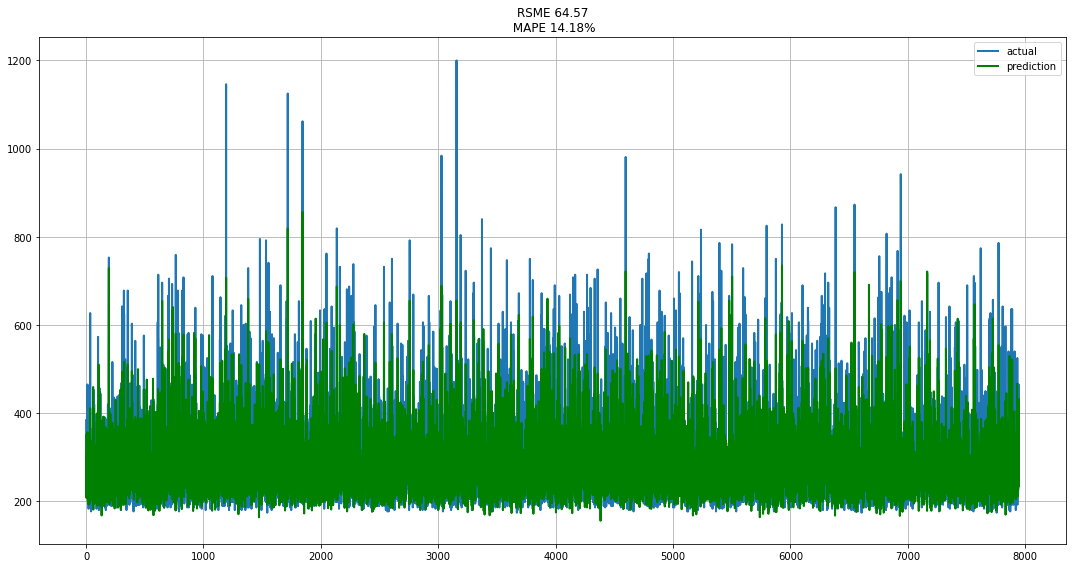

In [47]:
def deep_model_7():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(14,activation='relu',kernel_initializer='he_uniform',input_shape=(14,)))
  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer='he_uniform'))
  model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  return model

estimator = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=deep_model_7, epochs=100, batch_size=16, verbose=1)
estimator.fit(X_train_scaled,y_train)
plotModelResults(estimator,plot_intervals=False,X_test=X_test_scaled)
create_submission_file(estimator,"deep_model_7")

In [47]:
# Model XGB has performed the best secured 21 in private leaderboard
# nn completly overfit